In [17]:
!pip3 install --upgrade accelerate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Nombre del modelo
model_name = "dccuchile/bert-base-spanish-wwm-cased"

# Paso 1: Descargar el tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.save_pretrained("modelos/beto-tokenizer")

# Paso 2: Descargar el modelo base (sin clasificar aún)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.save_pretrained("modelos/beto-classifier")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("modelos/beto-tokenizer")
model = AutoModelForSequenceClassification.from_pretrained("modelos/beto-classifier")


In [19]:
from datasets import Dataset
import pandas as pd

data = {
    "text": [
        "¿Cuál es la capital de Perú?",
        "¿Por qué crees que el arte moderno es tan popular?",
        "¿Quién fue el primer presidente del Perú?",
        "¿Qué opinas sobre el cambio climático?",
    ],
    "label": [0, 1, 0, 1]  # 0 = factual, 1 = opinion
}

df = pd.DataFrame(data)
dataset = Dataset.from_pandas(df)


In [20]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

dataset = dataset.map(tokenize, batched=True)

Map: 100%|██████████| 4/4 [00:00<00:00, 656.39 examples/s]


In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Dividir en entrenamiento y validación
dataset = dataset.train_test_split(test_size=0.25)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds)
    }

args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/var/folders/b9/czfvlssj4z163jnpkkzwnvgr0000gn/T/ipykernel_73341/2653628895.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
trainer.train()

TypeError: Accelerator.unwrap_model() got an unexpected keyword argument 'keep_torch_compile'

In [ ]:
text = "¿Qué sabes del Imperio Inca?"

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
outputs = model(**inputs)
predicted_class = outputs.logits.argmax().item()

print("Predicción:", "Factual" if predicted_class == 0 else "Opinión")


In [28]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch

# ✅ Datos de entrenamiento
data = {
    "text": [
        "¿Tienen disponible la lavadora Samsung?",
        "¿Hay stock de sillas de oficina?",
        "¿Está en promoción la cocina empotrable?",
        "¿Cuánto cuesta este taladro?",
        "¿Puedo recogerlo en tienda?",
        "¿Qué tal es la calidad de este escritorio?",
        "¿Cuál es la mejor marca para taladros?",
        "¿Qué me recomiendan para una sala pequeña?",
        "¿Cuál es la diferencia entre estos dos modelos?",
        "¿Qué opciones hay para baños pequeños?"
    ],
    "label": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]  # 0 = Cerrada, 1 = Abierta
}

dataset = Dataset.from_dict(data)

# ✅ Cargar modelo y tokenizer BETO
model_name = "dccuchile/bert-base-spanish-wwm-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ✅ Tokenizar el dataset
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=64)

tokenized_dataset = dataset.map(preprocess)

# ✅ Entrenamiento rápido
training_args = TrainingArguments(
    output_dir="./results",
    #num_train_epochs=4,
    num_train_epochs=1,
    per_device_train_batch_size=4,
    logging_steps=5,
    logging_dir="./logs",
    eval_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    eval_dataset=tokenized_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 10/10 [00:00<00:00, 1638.78 examples/s]


TypeError: Accelerator.unwrap_model() got an unexpected keyword argument 'keep_torch_compile'

In [25]:
from transformers import AutoTokenizer, AutoModel
import torch

# Define the model name
model_name = "dccuchile/bert-base-spanish-wwm-uncased"

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Example sentence
sentence = "Este es un ejemplo en español."

# Tokenize the sentence
inputs = tokenizer(sentence, return_tensors="pt")

# Perform inference
with torch.no_grad():
    outputs = model(**inputs)

# Print the hidden states (example)
print(outputs.last_hidden_state.shape)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([1, 9, 768])


In [26]:
import torch
from transformers import BertTokenizer, BertModel

# Load pre-trained model and tokenizer
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-cased')

# Pre-process input text
input_text = "Hola, ¿cómo estás?"
inputs = tokenizer.encode_plus(input_text, 
                                add_special_tokens=True, 
                                max_length=512, 
                                return_attention_mask=True, 
                                return_tensors='pt')

# Run input through model
outputs = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])

# Print output
print(outputs.last_hidden_state)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


tensor([[[ 0.3476, -0.1922, -0.1956,  ..., -0.4622,  0.1942,  0.0063],
         [ 0.2579, -0.4332, -0.1984,  ..., -0.4033, -0.1360,  0.0243],
         [-0.7633,  0.0132, -0.0737,  ..., -0.0311, -0.5246, -0.0170],
         ...,
         [ 0.0064, -0.5103, -0.3769,  ..., -0.6194,  0.3948, -0.6656],
         [-0.3284, -0.1754, -0.2113,  ..., -0.0937,  0.2410, -0.1889],
         [-0.8958, -1.0060, -0.5904,  ..., -0.5459, -0.1394, -0.8056]]],
       grad_fn=<NativeLayerNormBackward0>)


In [33]:
!pip3 install transformers==4.38.2 accelerate==0.27.2

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 26.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 17.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.21.2
    Uninstalling tokenizers-0.21.2:
      Successfully uninstalled tokenizers-0.21.2
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.8.1
    Uninstalling accelerate-1.8.1:
      Successfully uninstalled accelerate-1.8.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:m╸━━━━━━━━━━━━━ 2/3 [transformers]
      Successfully uninstalled transformers-4.53.290m━━━━━━━━━━━━━ 2/3 [transformers]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [transformers] [transformers]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflict

In [35]:
!pip3 show transformers accelerate torch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: transformers
Version: 4.38.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: autotrain-advanced, compressed-tensors, mlx-lm, peft, sentence-transformers, trl, vllm, xgrammar
---
Name: accelerate
Version: 0.27.2
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages
Requires: huggingface

In [38]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

# Detectar si hay GPU (opcional, pero usamos CPU aquí)
device = torch.device("cpu")

# Dataset de ejemplo (puedes ampliarlo con más datos reales)
data = {
    'text': [
        "¿Cuál es tu comida favorita?",          # Abierta
        "¿Te gusta el chocolate?",               # Cerrada
        "¿Por qué elegiste esa carrera?",        # Abierta
        "¿Vienes mañana?",                       # Cerrada
        "¿Cómo te sentiste después del examen?", # Abierta
        "¿Tienes hambre?"                        # Cerrada
    ],
    'label': [1, 0, 1, 0, 1, 0]  # 1 = abierta, 0 = cerrada
}

# Crear dataset
dataset = Dataset.from_dict(data)
train_test = dataset.train_test_split(test_size=0.3)
train_dataset = train_test['train']
test_dataset = train_test['test']

# Tokenizador BETO
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased")

def tokenize(example):
    return tokenizer(example['text'], padding='max_length', truncation=True, max_length=64)

train_dataset = train_dataset.map(tokenize)
test_dataset = test_dataset.map(tokenize)

# Modelo BETO para clasificación binaria
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-uncased", num_labels=2)
model.to(device)

# Funciones de métrica
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = accuracy_score(p.label_ids, preds)
    f1 = f1_score(p.label_ids, preds)
    return {"accuracy": acc, "f1": f1}

# Argumentos de entrenamiento (usando CPU)
training_args = TrainingArguments(
    output_dir="./beto-preguntas",
    eval_strategy="epoch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    logging_dir='./logs',
    logging_steps=10,
    no_cuda=True  # fuerza uso de CPU
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics    
)

# Entrenamiento
trainer.train()

# Evaluación
trainer.evaluate()


Map: 100%|██████████| 2/2 [00:00<00:00, 675.52 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/training_args.py:1604: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


TypeError: Accelerator.unwrap_model() got an unexpected keyword argument 'keep_torch_compile'

In [42]:
!pip3 install -U spacy spacy-lookups-data
!python3 -m spacy download es_core_news_sm 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp310-cp310-macosx_14_0_arm64.whl (5.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 66.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy━━━━━━━━━━━━━━━━━━━ 0/2 [spacy-lookups-data]
    Found existing installation: numpy 1.26.4 0/2 [spacy-lookups-data]
    Uninstalling numpy-1.26.4:━━━━━━━━━━━━━━ 0/2 [spacy-lookups-data]
      Successfully uninstalled numpy-1.26.4━ 0/2 [spacy-lookups-data]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [numpy]32m1/2 [numpy]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autotrain-advanced 0.8.36 requires accelerate==1.2.1, but you have accelerate 0.27.2 which is incompatible.
autotrain-advanced 0.8.36 requires huggingface-hub==0.27.0, but you have huggingface-hub 0.33.4 which is incompatible.
autotrai

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 52.0 MB/s eta 0:00:00a 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [43]:
import random

train_data = [
    ("¿Te gusta el helado?", {"cats": {"cerrada": 1.0, "abierta": 0.0}}),
    ("¿Por qué el cielo es azul?", {"cats": {"cerrada": 0.0, "abierta": 1.0}}),
    ("¿Qué piensas de la política actual?", {"cats": {"cerrada": 0.0, "abierta": 1.0}}),
    ("¿Vas a venir mañana?", {"cats": {"cerrada": 1.0, "abierta": 0.0}}),
    # Agrega más ejemplos...
]


In [46]:
import spacy
from spacy.util import minibatch, compounding
from spacy.training.example import Example

nlp = spacy.load("es_core_news_sm", disable=["lemmatizer"])
if "textcat" not in nlp.pipe_names:
    textcat = nlp.add_pipe("textcat", last=True)
else:
    textcat = nlp.get_pipe("textcat")

# … resto del código exactamente igual …


textcat.add_label("abierta")
textcat.add_label("cerrada")


1

In [47]:
from spacy.training.example import Example

optimizer = nlp.initialize()
n_iter = 10

for i in range(n_iter):
    random.shuffle(train_data)
    losses = {}
    batches = minibatch(train_data, size=compounding(4.0, 32.0, 1.001))
    for batch in batches:
        examples = []
        for text, annotations in batch:
            doc = nlp.make_doc(text)
            examples.append(Example.from_dict(doc, annotations))
        nlp.update(examples, sgd=optimizer, losses=losses)
    print(f"Iteración {i} - Pérdidas:", losses)


Iteración 0 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.25}
Iteración 1 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.23490776121616364}
Iteración 2 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.1970246285200119}
Iteración 3 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.15198659896850586}
Iteración 4 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.1063109040260315}
Iteración 5 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.06790086627006531}
Iteración 6 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.03979098051786423}
Iteración 7 - Pérdidas: {'tok2vec': 0.0, 'morphologizer': 0.0, 'parser': 0.0, 'ner': 0.0, 'textcat': 0.021397341042757034}
Iteración 8 - Pérdidas: {'tok2vec': 0.0,

In [49]:
def clasificar_pregunta(pregunta):
    doc = nlp(pregunta)
    scores = doc.cats
    etiqueta = max(scores, key=scores.get)
    return etiqueta, scores

#ejemplo = "¿Cuál es tu comida favorita?"
ejemplo = "¿Quieres que te prepare una comida?"
etiqueta, scores = clasificar_pregunta(ejemplo)
print(f"Clasificación: {etiqueta}, puntajes: {scores}")


Clasificación: cerrada, puntajes: {'abierta': 0.45497769117355347, 'cerrada': 0.5450223088264465}


In [1]:
from flask import Flask, jsonify
app = Flask(__name__)
@app.route('/saludo', methods=['GET'])
def saludo():
    return jsonify({'mensaje': 'Hola desde Colab!'})

In [3]:
!pip3 install pyngrok

In [10]:
'''
from pyngrok import ngrok
ngrok.set_auth_token("1o4ItumAvMRlaYTG9dxyHKNInZq_48f9Txagc76SkaUUpoZB4")
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

public_url = ngrok.connect(8080)
print(public_url)
'''

from fastapi import FastAPI
from pydantic import BaseModel
#from pyngrok import ngrok
import nest_asyncio
import uvicorn

# Necesario para que funcione en Colab
nest_asyncio.apply()

# Define la app
app = FastAPI()

# Define un esquema de entrada
class Pregunta(BaseModel):
    texto: str
    lol: list

# Endpoint de prueba
@app.get("/clasificar")
def clasificar(pregunta: Pregunta):
    texto = pregunta.texto
    lol = pregunta.lol
    # Aquí puedes poner el matcher de spaCy o un clasificador
    return {"categoria": "CONSULTA_RECOMENDACION","lolo":lol}

# Inicia el tunel ngrok
#public_url = ngrok.connect(8000)
#print(f"🔗 API disponible en: {public_url}")

# Inicia el servidor
uvicorn.run(app, port=8000)


INFO:     Started server process [24172]
INFO:     Waiting for application startup.
Task exception was never retrieved
future: <Task finished name='Task-1' coro=<Server.serve() done, defined at /Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uvicorn/server.py:68> exception=KeyboardInterrupt()>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uvicorn/main.py", line 579, in run
    server.run()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/uvicorn/server.py", line 66, in run
    return asyncio.run(self.serve(sockets=sockets))
  File "/Users/andlody/Library/Python/3.10/lib/python/site-packages/nest_asyncio.py", line 30, in run
    return loop.run_until_complete(task)
  File "/Users/andlody/Library/Python/3.10/lib/python/site-packages/nest_asyncio.py", line 92, in run_until_complete
    self._run_once()
  File "/Users/andlody/Library/Python/3.1

INFO:     127.0.0.1:61305 - "GET /clasificar HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:61312 - "GET /clasificar HTTP/1.1" 200 OK
INFO:     127.0.0.1:61319 - "GET /clasificar HTTP/1.1" 200 OK
INFO:     127.0.0.1:61328 - "GET /clasificar HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [24172]


In [11]:
!pip3 install bert-score

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 490.50it/s]

done in 0.61 seconds, 8.22 sentences/sec


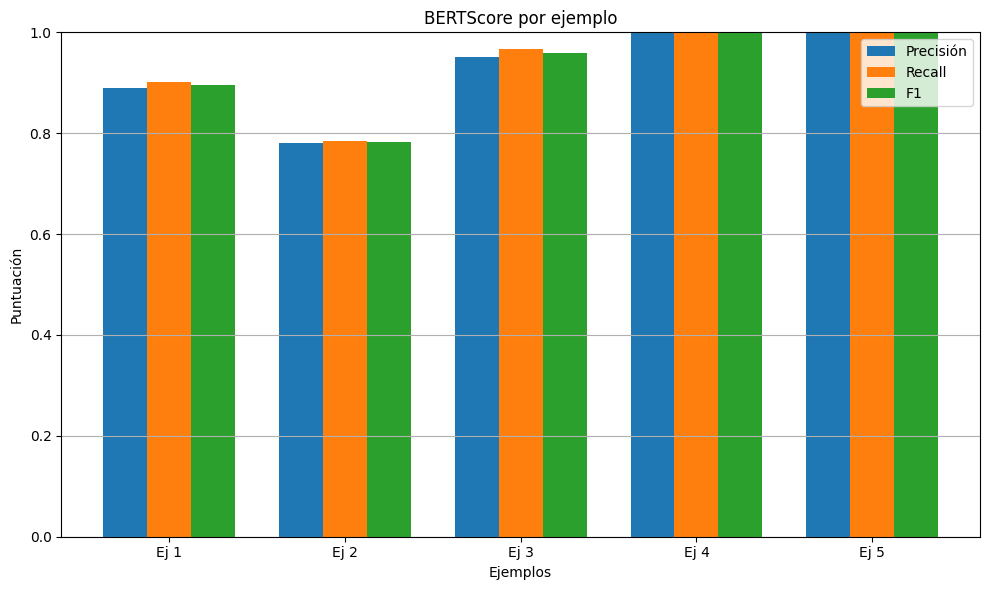

In [14]:
from bert_score import score
import matplotlib.pyplot as plt

# Candidatos y referencias
candidatos = [
    "El gato está sentado sobre la alfombra",
    "El perro ladra fuerte",
    "El ovalin es un prodcto bueno",
    "El perro ladra fuerte",
    "El perro ladra fuerte"
]

referencias = [
    "El felino se encuentra en la alfombra",
    "El canino hace ruido",
    "El ovalin es un prodcto malo",
    "El perro ladra fuerte",
    "El perro ladra fuerte"
]

# Calcular BERTScore
P, R, F1 = score(candidatos, referencias, lang="es", verbose=True)

# Convertir a listas de floats
P = P.tolist()
R = R.tolist()
F1 = F1.tolist()

# Crear gráfico de barras para cada métrica por ejemplo
x = range(len(candidatos))  # índices de cada par de ejemplo

plt.figure(figsize=(10, 6))
plt.bar(x, P, width=0.25, label="Precisión", align='center')
plt.bar([i + 0.25 for i in x], R, width=0.25, label="Recall", align='center')
plt.bar([i + 0.50 for i in x], F1, width=0.25, label="F1", align='center')

# Etiquetas y título
plt.xlabel("Ejemplos")
plt.ylabel("Puntuación")
plt.title("BERTScore por ejemplo")
plt.xticks([i + 0.25 for i in x], [f"Ej {i+1}" for i in x])
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y')

plt.tight_layout()
plt.show()
